In [2]:
#Import the necessary packages
from pyDOE import lhs#Design of Experiment, used to generate test points efficiently
from time import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


In [3]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the the neural network for PINN model."""

    def __init__(self, lb, ub, output_dim=1, num_hidden_layers=8, num_neurons_per_layer=20, activation='tanh', kernel_initializer='glorot_normal', **kwargs):
        #Be careful when using the "Relu" activation since it will become 0 if we want to compute the second derivatives.
        super().__init__(**kwargs)
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: (x - lb)/(ub - lb) ) # Set x belogns to [0,1]
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get(
            activation), kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


# Try to solve $u_{t}=u_{xx}+u_{yy}$ in $[0,1]^{2} *[0,1]$
## with B.C. uniformly 0, consistent with the initial condition
## with I.C. $u(x,y,0)=sin(\pi x)sin(\pi y)$
## Theoretical Solution $u(x,y,t) = e^{-2 \pi^{2} t} sin(\pi x)sin(\pi y)$

In [4]:
# Define the lower and upper bounds for the solution region
lb = tf.constant((0, 0, 0), dtype=DTYPE)
ub = tf.constant((1, 1, 1), dtype=DTYPE)


In [5]:
import math
def data_prepare(N_b, N_0, N_r, lb, ub):
    
    '''
    The function is used to generate training 
    
    Parameters
    ----------
    N_b: number of points in EACH EDGE
    N_0: number of points at t=0
    N_r: number of interior points

    '''
    def heat_u_0(X):
        """Pose the intial condition. """
        x=X[:,0:1]
        y=X[:,1:2]
        return tf.sin(math.pi * x)* tf.sin(math.pi * y)
    def heat_u_b(X):
        """Pose the boundary condition"""
        return tf.zeros((X.shape[0],1),dtype= DTYPE)
#Specify boundary condition
    x_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
    y_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)
    aux = tf.ones((N_b, 1), dtype=DTYPE)
    #Four edges
    x_b0 = tf.concat([x_b, aux*lb[1]], axis=1)
    x_b1 = tf.concat([x_b, aux*ub[1]], axis=1)
    y_b0 = tf.concat([aux*lb[0], y_b], axis=1)
    y_b1 = tf.concat([aux*ub[0], y_b], axis=1)
    #All boundary points, totally 4*N_b
    X_b = tf.concat([tf.concat([x_b0, x_b1, y_b0, y_b1], axis=0),tf.random.uniform((4*N_b,1),lb[2],ub[2],dtype=DTYPE)],axis=1)
    #Values on the boundary
    u_b = heat_u_b(X_b)

#Specify Initial condition

    X_0 = tf.concat([lhs(2,N_0),tf.zeros((N_0,1),dtype=DTYPE)],axis=1)
    u_0 = heat_u_0(X_0)

#Generate interior points

    X_f = lb+(ub-lb)*lhs(3,N_r)
    #X_f = lb+(ub-lb)*lhs(2, N_r)  # Randon Initial prediction
    return X_b, u_b, X_0, u_0, X_f


In [6]:
#Generate 200 points on boundary and 200 points at t=0. Then 8000 points in the interior
X_b, u_b, X_0, u_0, X_f = data_prepare(50,200,8000,lb,ub)

In [7]:
model = PINN_NeuralNet(lb, ub, num_hidden_layers=2, num_neurons_per_layer=20, activation='tanh', kernel_initializer='he_normal')
model.build(input_shape=(None, 3))
#Learning rate settings
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 7000,15000,30000], [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
optim = tf.keras.optimizers.Adam(learning_rate=lr)


In [8]:
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 7000], [1e-3, 1e-4,1e-5])
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def test_step():
    with tf.GradientTape(persistent=True) as tape:
        #Compute the gradients of network variables to use gradient descent
        tape.watch(model.trainable_variables)
        x = X_f[:, 0:1]
        y = X_f[:, 1:2]
        t = X_f[:, 2:3]
        #Compute the gradients of x,y,t
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                g.watch(t)
                # Compute current values u(x,y)
                u = model(tf.stack([x[:, 0], y[:, 0],t[:,0]], axis=1))
            u_x = g.gradient(u, x)
            u_y = g.gradient(u, y)
            u_t = g.gradient(u, t)
            del g
        u_xx = gg.gradient(u_x, x)
        u_yy = gg.gradient(u_y, y)
        del gg

        loss = tf.reduce_mean(tf.square(u_xx+u_yy-u_t))
        temp1=0
        temp2=0
        #Compute the loss on the boundary (Supervised Learning)
        for i in range(len(X_b)):
            u_pred = model(tf.expand_dims(X_b[i], 0))
            #MSE
            temp1 += tf.reduce_mean(tf.square(u_b[i] - u_pred))
        #Compute the loss at t=0(Supervised Learnign)
        for i in range(len(X_0)):
            u_pred = model(tf.expand_dims(X_0[i], 0))
            #MSE
            temp2 += tf.reduce_mean(tf.square(u_0[i] - u_pred))
        loss+=temp1/len(X_b)+temp2/len(X_0)

    # gradient of the trainable variables    
    g = tape.gradient(loss, model.trainable_variables)
    del tape
    optim.apply_gradients(zip(g, model.trainable_variables))
    return loss


In [23]:
#load the model weights preivously saved locally
path = "Heat_PINN_weights.h5"
model.load_weights(path)


In [10]:
#Examine the performance of previously trained model
test_step()

<tf.Tensor: shape=(), dtype=float32, numpy=5.894623e-05>

In [26]:
#Training Test procedure without saving
for i in range(1000):
    test_step()
test_step()


<tf.Tensor: shape=(), dtype=float32, numpy=0.0166226>

In [65]:
#Main traning procedure with saving
path = "Heat_PINN_weights.h5"
cnt = 1
for i in range(100000):
    test_step()
    if i % 2000==0:
        model.save_weights(path)
        print("The %d th weights has been saved" %cnt)
        cnt += 1


The 1 th weights has been saved
The 2 th weights has been saved
The 3 th weights has been saved
The 4 th weights has been saved
The 5 th weights has been saved
The 6 th weights has been saved
The 7 th weights has been saved
The 8 th weights has been saved
The 9 th weights has been saved
The 10 th weights has been saved
The 11 th weights has been saved
The 12 th weights has been saved
The 13 th weights has been saved
The 14 th weights has been saved
The 15 th weights has been saved
The 16 th weights has been saved
The 17 th weights has been saved
The 18 th weights has been saved
The 19 th weights has been saved
The 20 th weights has been saved
The 21 th weights has been saved
The 22 th weights has been saved
The 23 th weights has been saved
The 24 th weights has been saved
The 25 th weights has been saved
The 26 th weights has been saved
The 27 th weights has been saved
The 28 th weights has been saved
The 29 th weights has been saved
The 30 th weights has been saved
The 31 th weights h

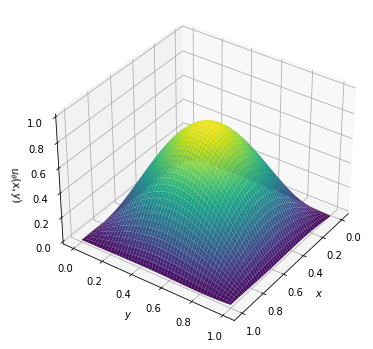

In [9]:
#Plot the result

N = 600
xspace = np.linspace(lb[0], ub[0], N)
yspace = np.linspace(lb[1], ub[1], N)
X, Y = np.meshgrid(xspace, yspace)
t = tf.ones((N*N,1),dtype=DTYPE)*0.01
Xgrid = tf.concat([np.vstack([X.flatten(), Y.flatten()]).T,t],axis=1)
upred = model(tf.cast(Xgrid, DTYPE))
U = upred.numpy().reshape(N, N)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,1)
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_\\theta(x,y)$')
ax.view_init(35, 35)


# Compare with the true value to compute $L_{2}$ loss
## loss(t) = $\int_0^1 \int_0^1 f(x,y,t)dxdy$
## , where $f(x,y,t)=|true(x,y,t)-pred(x,y,t)|^2$

In [41]:
def true(x,y,t):
    return math.pow(math.e,-2*math.pi*math.pi*t)*math.sin(math.pi*x)*math.sin(math.pi*y)
def pred(x,y,t):
    temp = tf.expand_dims(tf.constant((x, y, t), dtype=DTYPE), 0)
    return model(temp).numpy()[0][0]
def f(x,y,t):
    return math.pow(true(x,y,t)-pred(x,y,t),2)


# Gauss Integral Formula
## $\int_a^b f(x)dx=\frac{b-a}{2} \sum_{i=1}^n w_if(\frac{b-a}{2}x_i+\frac{a+b}{2})$
## In this case 
## $\int_0^1 \int_0^1 f(x,y,t)dxdy \approx \frac{1}{4} \sum_{j=1}^N w_j \sum_{i=1}^N w_i f(x_i,y_j,t)$

In [52]:
from scipy.special import roots_legendre
def Gauss_Integral(f,N,t):
    """
    Compute the L_2 loss of function f at time t with N points in each dimension through Gauss Integral formula
    """
    xi, w = roots_legendre(N)

    # To change range[-1,1] to range [0,1] as needed
    x = xi/2+1/2
    y=x
    sum =0
    for j in range(N):
        temp = 0
        for i in range(N):
            temp+=w[i]*f(x[i],y[j],t)
        sum+=w[j]*temp
    return sum/4

In [56]:
error_list = []
for t in range(0,100):
    error_list.append(Gauss_Integral(f,20,t*0.01))

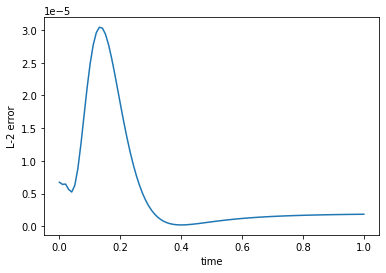

In [62]:
import matplotlib.pyplot as plt
temp = np.linspace(0, 1, 100)
plt.figure()
plt.xlabel('time')
plt.ylabel('L-2 error')
plt.plot(temp,error_list)
plt.savefig('L_2 error for heat equation.png')


# Save the data for plot purpose
# See "plot_only.ipynb"

In [16]:
import numpy as np
N = 600
xspace = np.linspace(lb[0], ub[0], N)
yspace = np.linspace(lb[1], ub[1], N)
X, Y = np.meshgrid(xspace, yspace)

predictions = np.zeros((100,600,600))

#Only save data for the first 0.1 second
#Each time slice, save data for 600*600 points

for i in range(100):
    t = tf.ones((N*N, 1), dtype=DTYPE)*0.001*i
    Xgrid = tf.concat([np.vstack([X.flatten(), Y.flatten()]).T, t], axis=1)
    upred = model(tf.cast(Xgrid, DTYPE))
    U = upred.numpy().reshape(N, N)
    predictions[i]=U


In [15]:
np.save('Predictions.npy',predictions)